In [1]:
%matplotlib inline
import numpy as np
import os
from datavyz import ges as ge

# Simulations with synaptic mechanisms only

The data are generated by looping over:

    - background activity levels
    - seeds for the background activity
    - stimulus intensity (the number of synapses recruited)
    - the stimulus properties (here the seed that shape the random synaptic sequence).

This loop over four conditions is implemented in the bash script: [./bash/BG.sh](./bash/BG.sh)

You can run it with:

> sh bash/BG.sh

## Load population data from individual sims (seeds & bg-levels)

In [12]:
from analyz.IO.files_manip import get_files_with_given_exts
from analyz.IO.npz import load_dict

def build_full_dataset(key='passive',
                       filename_only=True,                       
                       nfile_start=0, nfile_stop=int(1e8)):
    filenames = get_files_with_given_exts('data/bg-modul/%s' % key, '.npz')
    RESP = {'filename':[]}
    K = ['Vm_soma', 't', 'BG_raster', 'STIM_raster']
    KEYS = ['seed', 'stimseed', 'alphaZn','syn_location', 'bg_level', 'NSTIMs', 'ampa_only',
            'duration_per_bg_level', 'stim_delay']
    for key in KEYS+K:
        RESP[key] = []

    for i, fn in enumerate(filenames[nfile_start:nfile_stop]):
        if os.path.isfile(fn):
            try:
                data = load_dict(fn)
                if np.isfinite(data['Vm_soma'].max()):
                    RESP['filename'].append(fn)
                    for key in KEYS:
                        RESP[key].append(data['args'][key])
                    if not filename_only:
                        for key in K:
                            RESP[key].append(data[key])    
            except (KeyError, AttributeError):
                print(fn, 'not valid')
    for key in KEYS:
        RESP[key] = np.array(RESP[key])
        
    return RESP

In [415]:
RESP = build_full_dataset(key='passive', filename_only=True)

In [420]:
def plot_single_sim_data(RESP, 
                      alphaZn=[0, 0.3, 0.45],
                      view=[-200,600],  
                      shift=20,   
                      with_ampa_only=False,
                      NSTIMs=None,   
                      bg_level=0.,
                      syn_location=0,  
                      seed=0,
                      stimseed=0, 
                      COLORS=[ge.green, ge.orange, 'k'], LWS=range(1, 5),
                      ampa_color=ge.blue,
                     figsize=(2.2,.15),
                      VLIM=[-85, 30]):
    """
    Show raw simulation data
    """
    cond = np.zeros(len(RESP['bg_level']), dtype=bool)
    
    CONDS = [((RESP['alphaZn']==aZn) & (RESP['ampa_only']==False)) for aZn in alphaZn]
                      
    # adding the alpha levels
    for acond in CONDS:
        cond = cond | acond
        
    cond = cond & (RESP['bg_level']==bg_level)
    cond = cond & (RESP['syn_location']==syn_location)
        
    # adding the same bg-seed and stim-seed condition
    AVAILABLE_BG_SEEDS, AVAILABLE_STIM_SEEDS = [], []
    for acond in CONDS:
        AVAILABLE_BG_SEEDS.append(np.unique(RESP['seed'][cond & acond]))
        AVAILABLE_STIM_SEEDS.append(np.unique(RESP['stimseed'][cond & acond]))
    available_bg_seeds = np.intersect1d(*AVAILABLE_BG_SEEDS)   
    available_stim_seeds = np.intersect1d(*AVAILABLE_STIM_SEEDS)   
    #print(available_bg_seeds, available_stim_seeds)
    cond = cond &\
            (RESP['seed']==available_bg_seeds[seed]) &\
            (RESP['stimseed']==available_stim_seeds[stimseed])
    
    if with_ampa_only:
        CONDS.append((RESP['ampa_only']==True))
        COLORS.append(ampa_color)    
    
    fig, [ax, ax2] = ge.figure(axes_extents=[[[1,6]], [[1,4]]], figsize=figsize, hspace=0., left=.2)
    
    for acond, color, lw in zip(CONDS, COLORS, LWS):
        icond = np.argwhere(cond & acond)
        if len(icond)>0:
            i0= icond[0][0]
            if NSTIMs is None:
                NSTIMS = RESP['NSTIMs'][i0]
            iplot = 0
            data = load_dict(RESP['filename'][i0])
            tt, Vm = data['t'], data['Vm_soma']
            BG_raster, STIM_raster = data['BG_raster'], data['STIM_raster']
            for istim, nstim in enumerate(RESP['NSTIMs'][i0]):
                if nstim in NSTIMs:
                    t0 = istim*RESP['duration_per_bg_level'][i0]+view[0]+RESP['stim_delay'][i0]                        
                    t1 = t0+view[1]-view[0]
                    
                    tcond = (tt>=t0) & (tt<t1)
                    t, v = tt[tcond], Vm[tcond]
                    ax.plot(t-t0+iplot*(shift+view[1]-view[0]), v, color=color, lw=lw)
                    
                    if color==COLORS[0]:
                        for i, sp0 in enumerate(BG_raster):
                            sp = np.array(sp0)
                            spcond = (sp>=t0) & (sp<t1)
                            ax2.scatter(sp[spcond]-t0+iplot*(shift+view[1]-view[0]),
                                            i*np.ones(len(sp[spcond])), color=ge.purple, s=3)
                
                        for i, sp0 in enumerate(STIM_raster):
                            sp = np.array(sp0)
                            spcond = (sp>=t0) & (sp<t1)
                            ax2.scatter(sp[spcond]-t0+iplot*(shift+view[1]-view[0]),
                                        i*np.ones(len(sp[spcond])), color=ge.orange, s=3)
                    if bg_level==0.:
                        ge.annotate(ax2, '$N_{syn}$=%i' % nstim, 
                                            (iplot*(shift+view[1]-view[0])-view[0], i), va='top',
                                            xycoords='data',rotation=90,color=ge.orange,ha='right',size='x-small')

                    iplot+=1
        else:
            print('data not found for color:', color)
    #if bg_level==0.:
    #    fig.suptitle('loc-ID=%i, bg-seed=%i, stim-seed=%i' % (syn_location, available_bg_seeds[seed],
    #                                                    available_stim_seeds[stimseed]))
    ge.annotate(ax2, '$\\nu_{bg}$=%.1fHz' % bg_level, (0,0), color=ge.purple, rotation=90, ha='right')
    ge.set_plot(ax, [], xlim=[0, iplot*(shift+view[1]-view[0])], ylim=VLIM)
    ge.set_plot(ax2, [], xlim=[0, iplot*(shift+view[1]-view[0])], ylim=[0,i])

    ge.draw_bar_scales(ax, 
                       Xbar = 200, Xbar_label='200ms',
                       Ybar = 15, Ybar_label='15mV ',
                       loc=(0.1,.9), orientation='right-bottom')
    return fig

data not found for color: #1f77b4
data not found for color: #1f77b4


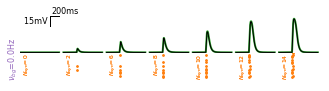

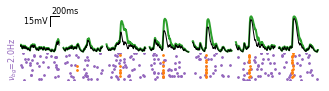

In [422]:
props= {'NSTIMs':[0, 2, 6, 8, 10, 12, 14], 
        'syn_location':1, 'seed':1, 'stimseed':0, 'VLIM':[-76,-15],
        'alphaZn':[0., 0.45], 'COLORS':[ge.green, 'k'], 'LWS':[2,1,1],
        'with_ampa_only':True,
        'shift':100, 'view':[-300,600]}
fig = plot_single_sim_data(RESP, bg_level=0., **props)
fig = plot_single_sim_data(RESP, bg_level=2., **props)

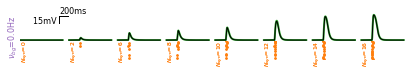

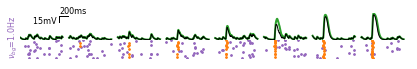

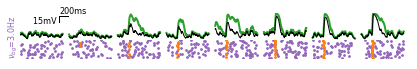

In [421]:
props= {'NSTIMs':[0, 2, 6, 8, 10, 12, 14, 16], 
        'syn_location':0, 'seed':4, 'stimseed':1, 'VLIM':[-76,-15],
        'alphaZn':[0., 0.45], 'COLORS':[ge.green, 'k'], 'LWS':[2,1],
        'with_ampa_only':True, 'figsize':(2.5,.1),
        'shift':150, 'view':[-250,750]}
plot_single_sim_data(RESP, bg_level=0., **props).savefig('figures/fig11a.svg')
plot_single_sim_data(RESP, bg_level=1., **props).savefig('figures/fig11b.svg')
plot_single_sim_data(RESP, bg_level=3., **props).savefig('figures/fig11c.svg')

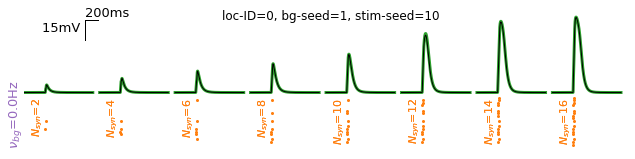

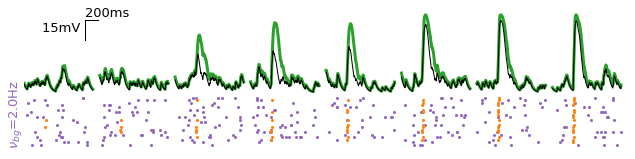

In [134]:
props= {'NSTIMs':[2, 4, 6, 8, 10, 12, 14, 16], 
        'syn_location':0, 'seed':1, 'stimseed':0, 'VLIM':[-76,-15],
        'alphaZn':[0., 0.45], 'COLORS':[ge.green, 'k'], 'LWS':[3,1],
        'with_ampa_only':False,
        'shift':100, 'view':[-300,700]}
fig = plot_single_sim_data(RESP, bg_level=0., **props)
fig = plot_single_sim_data(RESP, bg_level=2., **props)

In [402]:
from analyz.IO.files_manip import get_files_with_given_exts
from analyz.IO.npz import load_dict

def count_spikes(t, Vm, t0, t1, threshold=0):
    cond = (t>t0) & (t<t1)
    return len(np.argwhere((Vm[cond][:-1]<threshold) & (Vm[cond][1:]>=threshold)))

def build_full_dataset_per_stim(key='passive',
                                nfile_start=0, nfile_stop=int(1e8),
                                filename_only=True,
                                spike_window=200):
    filenames = get_files_with_given_exts('data/bg-modul/%s' % key, '.npz')
    RESP_PER_STIM = {'Vm':[], 'freq':[], 'Nspike':[], 'spike':[], 'nstim':[], 'filename':[]}
    KEYS = ['seed', 'stimseed', 'alphaZn','syn_location', 'bg_level', 'ampa_only']
    for k in KEYS:
        RESP_PER_STIM[k] = []

    for fn in filenames[nfile_start:nfile_stop]:
        if not os.path.isdir(fn):
            data = load_dict(fn)
            if np.isfinite(data['Vm_soma'].max()) and ('stimseed' in data['args']):
                for i, nstim in enumerate(data['args']['NSTIMs']):
                    t0 = i*data['args']['duration_per_bg_level']
                    t1 = t0+data['args']['duration_per_bg_level']
                    tcond = (data['t']>=t0) & (data['t']<t1)
                    RESP_PER_STIM['Vm'].append(data['Vm_soma'][tcond])
                    RESP_PER_STIM['nstim'].append(nstim)
                    for k in KEYS:
                        RESP_PER_STIM[k].append(data['args'][k])
                    if key=='active':
                        n = count_spikes(data['t'], data['Vm_soma'],
                                            data['args']['stim_delay']+t0,
                                            data['args']['stim_delay']+t0+spike_window)
                    else:
                        n=0
                    RESP_PER_STIM['Nspike'].append(n)
                    RESP_PER_STIM['spike'].append(np.sign(n)) # 0/1 spike/no-spike
                    RESP_PER_STIM['freq'].append(n/spike_window*1e3)
                RESP_PER_STIM['t'] = data['t'][tcond]-t0
                RESP_PER_STIM['stim_delay'] = data['args']['stim_delay']
    for key in RESP_PER_STIM.keys():
        RESP_PER_STIM[key] = np.array(RESP_PER_STIM[key])
    return RESP_PER_STIM

#RESP_PER_STIM = build_full_dataset_per_stim(key='passive')

In [141]:
RESP_PER_STIM = build_full_dataset_per_stim(key='passive', nfile_stop=4000)

In [409]:
RESP_PER_STIM = build_full_dataset_per_stim(key='prev-active')

In [142]:
def show_trial_average_responses(RESP_PER_STIM, resp='', 
                                 alphaZn=0., 
                                 VLIM=None,
                                 syn_location='all',
                                 window=[-200,400]):

    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    else:
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==alphaZn)
        resp = '$\\alpha_{Zn}$=%.2f' % alphaZn
    if syn_location is not 'all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
        sloc = 'loc #%i' % syn_location
    else:
        sloc = 'Nloc=%i' % len(np.unique(RESP_PER_STIM['syn_location']))
        
    bg_levels = np.unique(RESP_PER_STIM['bg_level'])
    fig, AX = ge.figure(axes=(len(bg_levels),1), wspace=0.1, right=1.3)
    
    fig.suptitle('%s, n=%i bg seeds, n=%i stim seeds, %s' % (resp,
                                                    len(np.unique(RESP_PER_STIM['seed'])),
                                                    len(np.unique(RESP_PER_STIM['seed'])), # STIM SEED HERE !
                                                    sloc))
    t = RESP_PER_STIM['t']
    ylim, ylim2 = [np.inf, -np.inf], [np.inf, -np.inf]
    for ibg, bg in enumerate(bg_levels):
        for istim, nstim in enumerate(np.unique(RESP_PER_STIM['nstim'])[::-1]):
            # raw responses
            scond = cond &\
                (RESP_PER_STIM['nstim']==nstim) & (RESP_PER_STIM['bg_level']==bg)
    
            tcond = (t>=RESP_PER_STIM['stim_delay']+window[0]) & (t<RESP_PER_STIM['stim_delay']+window[1])
            y0 = np.mean([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
            AX[ibg].plot(t[tcond], y0[tcond],lw=1,
                    color=ge.red_to_blue(1-istim/len(np.unique(RESP_PER_STIM['nstim']))))
            ylim = [-76, max([ylim[1],y0.max()])]
        AX[ibg].plot([t[tcond][0],t[tcond][-1]], -75*np.ones(2), 'k:', lw=0.5)
        ge.annotate(AX[ibg],'%.1fHz'%bg,(1,1),color=ge.purple,ha='right',va='top')
        
    for ibg, bg in enumerate(bg_levels):
        if VLIM is not None:
            ylim = VLIM
        ge.set_plot(AX[ibg], [], ylim=ylim)
    ge.draw_bar_scales(AX[0], Xbar = 200, Xbar_label='200ms',
                              Ybar = 10, Ybar_label='10mV',
                              loc=(0.05,.8), orientation='right-bottom')
    ge.bar_legend(fig, X=np.unique(RESP_PER_STIM['nstim']),
                  bounds=[0, np.unique(RESP_PER_STIM['nstim'])[-1]],
                  ticks_labels=['%i' % x if i%4==0 else '' for i, x in enumerate(np.unique(RESP_PER_STIM['nstim']))],
                  inset=dict(rect=[.999,.4,.016, .5]),
                  colormap=ge.red_to_blue, label='$N_{syn}$')


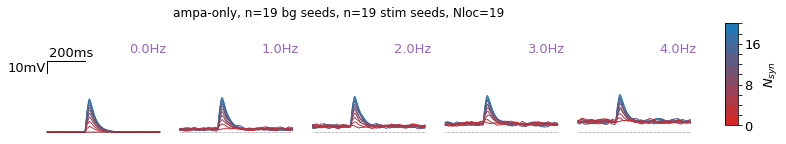

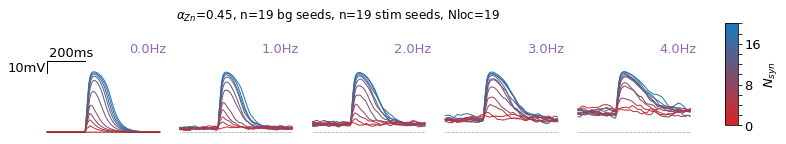

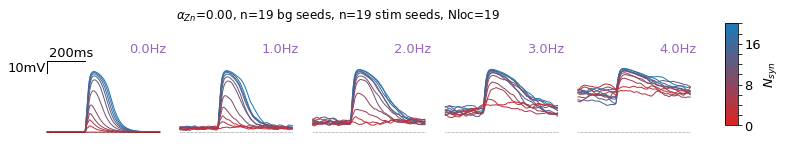

In [143]:
props = {'VLIM':[-76,0], 'syn_location':'all'}
show_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

In [144]:
def get_trial_average_responses(RESP_PER_STIM, resp='', 
                                alphaZn=0., 
                                syn_location='all',
                                baseline_window=[-100,0],
                                peak_window=[0,500],
                                integral_window=[0,500]):

    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    else:
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==alphaZn)
        resp = '$\\alpha_{Zn}$=%.2f' % alphaZn
    if syn_location is not 'all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
        sloc = 'loc #%i' % syn_location
    else:
        sloc = 'Nloc=%i' % len(np.unique(RESP_PER_STIM['syn_location']))
        
    bg_levels = np.unique(RESP_PER_STIM['bg_level'])

    t = RESP_PER_STIM['t']

    RESP = []
    
    for ibg, bg in enumerate(bg_levels):
        RESP.append({'nstims':[], 'Peak':[], 'Integral':[], 'Freq':[], 'bg_level':bg})
        for k in ['Peak', 'Integral', 'Freq']:
            RESP[-1][k], RESP[-1]['min'+k], RESP[-1]['max'+k] = [], [], []
            
        for istim, nstim in enumerate(np.unique(RESP_PER_STIM['nstim'])):
           
            RESP[ibg]['nstims'].append(nstim)
            scond = cond &\
                (RESP_PER_STIM['nstim']==nstim) & (RESP_PER_STIM['bg_level']==bg)
            # trial average
            y = np.mean([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
            sy = np.std([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
            # baseline
            BSLcond = (t>=RESP_PER_STIM['stim_delay']+baseline_window[0]) &\
                            (t<RESP_PER_STIM['stim_delay']+baseline_window[1])
            BSL = np.mean(y[BSLcond])
            # peak depol
            PEAKcond = (t>=RESP_PER_STIM['stim_delay']+peak_window[0]) &\
                            (t<RESP_PER_STIM['stim_delay']+peak_window[1])
            RESP[ibg]['Peak'].append(np.max(y[PEAKcond])-BSL)
            RESP[ibg]['minPeak'].append(np.max(y[PEAKcond]-sy[PEAKcond])-BSL)
            RESP[ibg]['maxPeak'].append(np.max(y[PEAKcond]+sy[PEAKcond])-BSL)
            # depol integral
            INTcond = (t>=RESP_PER_STIM['stim_delay']+integral_window[0]) &\
                            (t<RESP_PER_STIM['stim_delay']+integral_window[1])
            RESP[ibg]['Integral'].append(np.trapz(y[INTcond]-BSL, t[INTcond])/1e3)
            RESP[ibg]['minIntegral'].append(np.trapz(y[INTcond]-sy[PEAKcond]-BSL, t[INTcond])/1e3)
            RESP[ibg]['maxIntegral'].append(np.trapz(y[INTcond]+sy[PEAKcond]-BSL, t[INTcond])/1e3)
            RESP[ibg]['Freq'].append(np.mean([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
            RESP[ibg]['Proba'].append(np.mean([RESP_PER_STIM['spike'][i] for i, s in enumerate(scond) if s]))
            RESP[ibg]['minFreq'].append(RESP[ibg]['Freq'][-1]-np.std([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
            RESP[ibg]['maxFreq'].append(RESP[ibg]['Freq'][-1]+np.std([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
       
    return RESP
        
props = {'syn_location':'all'}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

In [ ]:
cmap = ge.blue_to_red #ge.get_linear_colormap(ge.orange, ge.purple)

# to fit
from scipy.optimize import minimize
def sigmoid_func(x, x0=0, sx=1.):
    return 1./(1+np.exp(-(x-x0)/(1e-9+np.abs(sx))))
        
def show_response_bg_dep(FREE, CHELATED, AMPA=None, 
                         method='Integral',
                         BG_levels=None,
                         ylim=None):
    
    if BG_levels is None:
        BG_levels = [R['bg_level'] for R in FREE]
        
    FWHM = {'Free':[], 'Chelated':[], 'Ampa':[]}
            
    fig, AX = ge.figure(axes=(1,2), figsize=(1,1.), hspace=0.3, right=1.5)
    fig2, ax = ge.figure(axes=(1,1), figsize=(1,1.), hspace=0.3, right=1.5)    
    
    i=0
    for ibg, bg in enumerate(BG_levels):
        """
        if bg_cond[ibg]:           
            if method=='peak':
                y0 = output1['peak'][ibg,:,:,:].mean(axis=(0,2))-output1['bsl'][ibg,:,:,:].mean()#axis=(0,2))
                y1 = output2['peak'][ibg,:,:,:].mean(axis=(0,2))-output2['bsl'][ibg,:,:,:].mean()#axis=(0,2))
            if method=='integral':
                y0 = 1e-3*output1['integral'][ibg,:,:,:].mean(axis=(0,2))
                y1 = 1e-3*output2['integral'][ibg,:,:,:].mean(axis=(0,2))
                
                
            for key, y, ax2 in zip(['L23', 'L4'], [y0, y1], AX):
                def to_minimize(coefs):
                    #return np.sum((y-y.max()*sigmoid_func(args['NSTIMs'], coefs[1], coefs[2]))**2)
                    return np.sum((y-y[0]-coefs[0]*sigmoid_func(args['NSTIMs'], coefs[1], coefs[2]))**2)
                res = minimize(to_minimize, [y.max()-y[0], np.mean(args['NSTIMs']), np.std(args['NSTIMs'])],
                              bounds=([0, 1.5*y.max()], [1, args['NSTIMs'][-1]], [1, args['NSTIMs'][-1]]))
                #FWHM[key].append(res.x[1]) # FWHM of fit isn't really good
                xx = np.linspace(0, max(args['NSTIMs']), 100)
                yy = res.x[0]*sigmoid_func(xx, res.x[1], res.x[2])
                i0 = np.argmin((yy.max()/2.-yy)**2)
                FWHM[key].append(xx[i0]) # FWHM of fit isn't really good
                #ax2.plot(args['NSTIMs'], res.x[0]*sigmoid_func(args['NSTIMs'], res.x[1], res.x[2]), ':',
                #        lw=1, color=cmap(i/(len(BG_levels)-1)))
                ax2.plot(np.ones(2)*res.x[1], [0, res.x[0]*sigmoid_func(res.x[1], res.x[1], res.x[2])], ':',
                        lw=1, color=cmap(i/(len(BG_levels)-1)))
        """
                
        if method[:5]=='delta':
            AX[0].plot(FREE[ibg]['nstims'], FREE[ibg][method[5:]]-FREE[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method[5:]]-CHELATED[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
        
        else:
            #AX[0].plot(FREE[ibg]['nstims'], FREE[ibg][method], lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            #AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method], lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            ge.plot(FREE[ibg]['nstims'],
                    FREE[ibg][method], 
                    sy=np.array(FREE[ibg]['max'+method])-np.array(FREE[ibg]['min'+method]),
                    ax=AX[0], 
                    lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            ge.plot(CHELATED[ibg]['nstims'],
                    CHELATED[ibg][method], 
                    sy=np.array(CHELATED[ibg]['max'+method])-np.array(CHELATED[ibg]['min'+method]),
                    ax=AX[1], 
                    lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            #print(np.array(FREE[ibg]['max'+method])-np.array(FREE[ibg]['min'+method]))
            #AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method], lw=1, color=cmap(ibg/(len(BG_levels)-1)))
        
        
    #ge.scatter(args['bg_levels'], FWHM['L23'], color='dimgrey', ax=ax, ms=3, lw=1, no_set=True)
    #ge.scatter(args['bg_levels'], FWHM['L4'], color=ge.green, ax=ax, ms=3, lw=1, no_set=True)
    
    ge.annotate(AX[0], 'L23-L23 syn.', (0., .95), size='small', color='dimgrey', bold=True)
    ge.annotate(AX[1], 'L4-L23 syn.', (0., .95), size='small', color=ge.green, bold=True)
    
    #if ylim is None:
    #    ylim = [min(ax.get_ylim()[0] for ax in AX), max(ax.get_ylim()[1] for ax in AX)]
        
    if method=='Integral':
        ylabel='PSP integ. (mV.s)'+20*' '
    if method=='Peak':
        ylabel='max. $\delta$ $V_m$ (mV)'+20*' '
    if method=='Freq':
        ylabel='Spike Freq. (Hz) '+20*' '
    if method=='deltaFreq':
        ylabel='$\delta$ Spike Freq. (Hz) '+20*' '
        
    ge.set_plot(AX[0], ['left'], ylabel=ylabel, ylim=ylim)
    ge.set_plot(AX[1], xlabel='$N_{syn}$', ylim=ylim)
    ge.set_plot(ax, xlabel='$\\nu_{bg}$ (Hz)', ylabel='$c_{50}$ ($N_{syn}$)')
    
    ge.bar_legend(fig,
                  X=[0]+BG_levels,
                  bounds=[-BG_levels[1]/2., BG_levels[-1]+BG_levels[1]/2],
                  inset=dict(rect=[.9,.3,.05, .5]),
                  label='$\\nu_{bg}$ (Hz)',
                  colormap=cmap)
    
    return fig, fig2

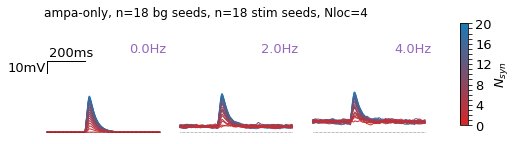

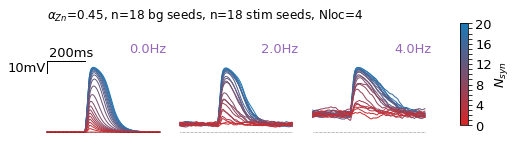

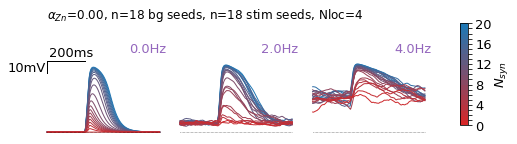

In [41]:
props = {'VLIM':[-76,0], 'syn_location':'all'}
show_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

In [293]:
# to fit
from scipy.optimize import minimize
def sigmoid_func(x, x0=0, sx=1.):
    return 1./(1+np.exp(-(x-x0)/(1e-9+np.abs(sx))))
        

def get_trial_average_responses(RESP_PER_STIM, resp='',
                                NSTIMS=None,
                                alphaZn=0., 
                                syn_location='all',
                                integral_threshold=4.,
                                baseline_window=[-100,0],
                                peak_window=[0,500],
                                integral_window=[0,500]):

    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    else:
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==alphaZn)
        resp = '$\\alpha_{Zn}$=%.2f' % alphaZn
    if syn_location is not 'all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
        sloc = 'loc #%i' % syn_location
    else:
        sloc = 'Nloc=%i' % len(np.unique(RESP_PER_STIM['syn_location']))
        
    bg_levels = np.unique(RESP_PER_STIM['bg_level'])

    t = RESP_PER_STIM['t']

    RESP = []
    if NSTIMS is None:
        NSTIMS = np.unique(RESP_PER_STIM['nstim'])
    
    for ibg, bg in enumerate(bg_levels):
        RESP.append({'nstims':[], 'Peak':[], 'Integral':[], 'Freq':[], 'Proba':[], 'bg_level':bg})
        for k in ['Peak', 'Integral', 'Freq', 'Proba']:
            RESP[-1][k], RESP[-1]['min'+k], RESP[-1]['max'+k] = [], [], []
            
        for istim, nstim in enumerate(np.unique(RESP_PER_STIM['nstim'])):
           
            if nstim in NSTIMS:
                RESP[ibg]['nstims'].append(nstim)
                scond = cond &\
                    (RESP_PER_STIM['nstim']==nstim) & (RESP_PER_STIM['bg_level']==bg)
                # trial average
                y = np.mean([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
                sy = np.std([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
                # baseline
                BSLcond = (t>=RESP_PER_STIM['stim_delay']+baseline_window[0]) &\
                                (t<RESP_PER_STIM['stim_delay']+baseline_window[1])
                BSL = np.mean(y[BSLcond])
                # peak depol
                PEAKcond = (t>=RESP_PER_STIM['stim_delay']+peak_window[0]) &\
                                (t<RESP_PER_STIM['stim_delay']+peak_window[1])
                RESP[ibg]['Peak'].append(np.max(y[PEAKcond])-BSL)
                #RESP[ibg]['minPeak'].append(np.max(y[PEAKcond]-sy[PEAKcond])-BSL)
                #RESP[ibg]['maxPeak'].append(np.max(y[PEAKcond]+sy[PEAKcond])-BSL)
                # depol integral
                INTcond = (t>=RESP_PER_STIM['stim_delay']+integral_window[0]) &\
                                (t<RESP_PER_STIM['stim_delay']+integral_window[1])
                RESP[ibg]['Integral'].append(np.trapz(y[INTcond]-BSL, t[INTcond])/1e3)
                #RESP[ibg]['minIntegral'].append(np.trapz(y[INTcond]-sy[PEAKcond]-BSL, t[INTcond])/1e3)
                #RESP[ibg]['maxIntegral'].append(np.trapz(y[INTcond]+sy[PEAKcond]-BSL, t[INTcond])/1e3)
                RESP[ibg]['Freq'].append(np.mean([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
                #RESP[ibg]['minFreq'].append(RESP[ibg]['Freq'][-1]-np.std([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
                #RESP[ibg]['maxFreq'].append(RESP[ibg]['Freq'][-1]+np.std([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
        x = NSTIMS
        for key in ['Peak', 'Integral', 'Freq']:
            y = np.array(RESP[ibg][key])
            def to_minimize(coefs):
                return np.sum((y-coefs[0]*sigmoid_func(x, coefs[1], coefs[2]))**2)
                #return np.sum((y-max(y)*sigmoid_func(x, coefs[1], coefs[2]))**2)

            res = minimize(to_minimize, [y.max()-y[0], np.mean(x), np.std(x)],
                            bounds=([0, 1.5*y.max()], [1, x[-2]], [1, x[-2]]))
            RESP[ibg][key+'-coeffs'] = res.x
            yf = res.x[0]*sigmoid_func(x, res.x[1], res.x[2])    
            #if key=='Integral':
            #    RESP[ibg]['Integral-threshold'] = np.array(x)[yf>integral_threshold].min()
            
       
    return RESP
        


In [ ]:
props = {'syn_location':'all'}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

In [348]:
from datavyz import ges as ge
cmap = ge.blue_to_red #ge.get_linear_colormap(ge.orange, ge.purple)

def show_response_bg_dep(FREE, CHELATED, AMPA=None,
                         ge=ge,
                         method='Integral',
                         BG_levels=None,
                         crossing=None,
                         ylim=None):
    
    if BG_levels is None:
        BG_levels = [R['bg_level'] for R in FREE]
        
    CS = [CHELATED, FREE]
    if AMPA is not None:
        CS.append(AMPA)
        fig, AX = ge.figure(axes=(1,3), figsize=(1,1.), hspace=0.3, right=1.5)
    else:
        fig, AX = ge.figure(axes=(1,2), figsize=(1,1.), hspace=0.3, right=1.5)

    #fig2, ax2 = ge.figure(axes=(1,1), figsize=(1,1.), hspace=0.3, right=1.5)    
    
    for ibg, bg in enumerate(BG_levels):
        if method[:5]=='delta':
            AX[0].plot(FREE[ibg]['nstims'], FREE[ibg][method[5:]]-FREE[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method[5:]]-CHELATED[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
        
        else:
            for C, ax in zip(CS, AX):
                # data
                ge.scatter(C[ibg]['nstims'], C[ibg][method], 
                        ax=ax, color=cmap(ibg/(len(BG_levels)-1)), no_set=True, lw=0.5, ms=2)
                # fit
                x, coefs = np.linspace(C[ibg]['nstims'][0], C[ibg]['nstims'][-1], 100), C[ibg][method+'-coeffs']
                y = coefs[0]*sigmoid_func(x, coefs[1], coefs[2])
                ge.plot(x, y, ax=ax, color=cmap(ibg/(len(BG_levels)-1)), no_set=True, lw=3, alpha=0.5)
                # ADDING THE c50 position:
                if crossing is not None:
                    try:
                        ix0 = min(np.argwhere(y>crossing).flatten())
                        ax.plot(np.ones(2)*x[ix0], [0,crossing], ':', lw=1, color=cmap(ibg/(len(BG_levels)-1)))
                    except ValueError:
                        pass
    if crossing is not None:
        for ax in AX[:2]:
            ax.plot([x[0], x[-1]], crossing*np.ones(2), ':', lw=0.5, color=ge.dimgrey)
        
    ge.annotate(AX[1], 'syn. props\nL23-L23', (0., .7), size='small', color='dimgrey', bold=True)
    ge.annotate(AX[0], 'syn. props\nL4-L23', (0., .7), size='small', color=ge.green, bold=True)
    
    if method=='Integral':
        ylabel='PSP integral (mV.s)'+10*' '
    if method=='Peak':
        ylabel='max. $\delta$ $V_m$ (mV)'+10*' '
    if method=='Freq':
        ylabel='Spike Freq. (Hz) '+10*' '
    if method=='Proba':
        ylabel='Spike Probability '+10*' '
    if method=='deltaFreq':
        ylabel='$\delta$ Spike Freq. (Hz) '+10*' '
        
    ge.set_plot(AX[0], ['left'], ylabel=ylabel, ylim=ylim)
    if AMPA is None:
        ge.set_plot(AX[0], ['left'], ylabel=ylabel, ylim=ylim)
        ge.set_plot(AX[1], xlabel='$N_{syn}$', ylim=ylim)
    else:
        ge.set_plot(AX[0], ['left'], ylim=ylim)
        ge.set_plot(AX[1], ['left'], ylabel=ylabel, ylim=ylim)
        ge.set_plot(AX[2], xlabel='$N_{syn}$', ylim=ylim)
        ge.annotate(AX[2], 'AMPA\nonly', (0., .55), size='small', color=ge.blue, bold=True)
        
        
    #ge.set_plot(ax2, xlabel='$\\nu_{bg}$ (Hz)', ylabel='$c_{50}$ ($N_{syn}$)')
    
    ge.bar_legend(fig,
                  X=[0]+BG_levels,
                  bounds=[-BG_levels[1]/2., BG_levels[-1]+BG_levels[1]/2],
                  inset=dict(rect=[.9,.3,.05, .5]),
                  label='$\\nu_{bg}$ (Hz)',
                  colormap=cmap)
    
    return fig #, fig2

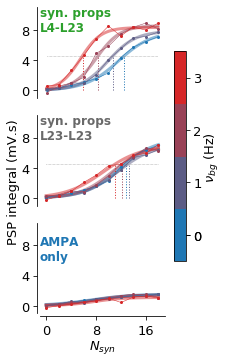

In [349]:
props = {'syn_location':0, 'NSTIMS':np.arange(0, 20, 2), 'integral_window':[0,300]}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)
fig_BG = show_response_bg_dep(FREE, CHELATED, AMPA=AMPA, method='Integral',
                                 ylim=[-1,11], BG_levels=[0,1,2,3], crossing=4.5)

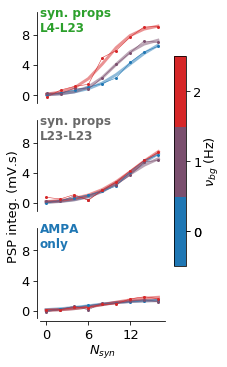

In [304]:
props = {'syn_location':0, 'NSTIMS':np.arange(0, 18, 2)}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)
fig_BG = show_response_bg_dep(FREE, CHELATED, AMPA=AMPA, method='Integral',
                                 ylim=[-1,11], BG_levels=[0,1,2])

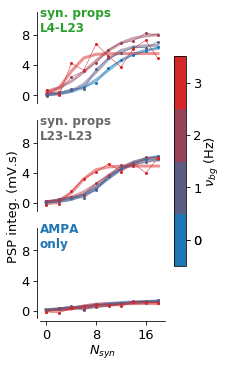

In [305]:
props = {'syn_location':3, 'NSTIMS':np.arange(0, 20, 2), 'integral_window':[0,300]}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)
fig_BG = show_response_bg_dep(FREE, CHELATED, AMPA=AMPA, method='Integral',
                                 ylim=[-1,11], BG_levels=[0,1,2,3])

(<Figure size 249.449x419.528 with 4 Axes>,
 <Figure size 249.449x204.094 with 1 Axes>)

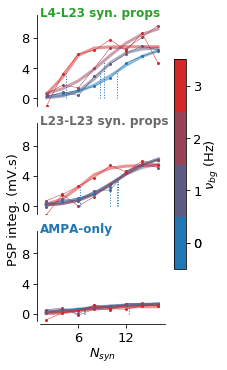

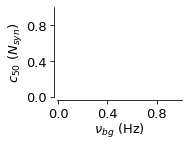

In [274]:
props = {'syn_location':2, 'NSTIMS':np.arange(2, 18, 2)}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)
show_response_bg_dep(FREE, CHELATED, AMPA=AMPA, method='Integral',
                     ylim=[-1,11], BG_levels=[0,1,2,3])

In [414]:
props = {'syn_location':2, 'NSTIMS':[2, 4, 6, 8]}
#AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)
show_response_bg_dep(FREE, CHELATED, method='Integral',
                     ylim=[-1,11], BG_levels=[0,1,2,3])

ValueError: operands could not be broadcast together with shapes (2,) (4,) 

# Lowering to $\alpha_{Zn}$=0.35

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

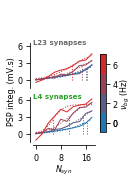

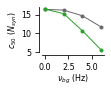

In [12]:
args.alphaZn = 0.35
data_L23_035 = load_dict(filename(args))
output_L23_035 = preprocess_sim(data_L23_035)
show_response_bg_dep(output_L23_035, output_L4, method='integral')

# Lowering to $\alpha_{Zn}$=0.25

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

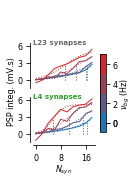

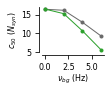

In [13]:
args.alphaZn = 0.25
data_L23_025 = load_dict(filename(args))
output_L23_025 = preprocess_sim(data_L23_025)
show_response_bg_dep(output_L23_025, output_L4, method='integral')

## method based on PSP peak deflection for comparison
--> worse

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

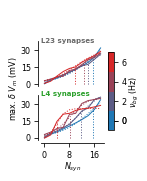

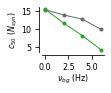

In [14]:
show_response_bg_dep(output_L23, output_L4, method='peak')

# With active mechanisms (voltage-gated channels, Calcium dynamics, ...)

In [94]:
RESP= build_full_dataset(key='active')

In [84]:
props= {'NSTIMs':[4, 6, 10, 14], 'syn_location':1, 'seed':0, 'VLIM':[-86,15],
        'shift':20, 'view':[-200,400]}
fig = plot_single_sim_data(RESP, bg_level=0., **props)
fig = plot_single_sim_data(RESP, bg_level=2., **props)
fig = plot_single_sim_data(RESP, bg_level=4., **props)

NameError: name 'RESP' is not defined

In [105]:
RESP_PER_STIM = build_full_dataset_per_stim(key='active')

In [126]:
np.unique(RESP_PER_STIM['freq'])

array([ 0.,  5., 10., 15., 20., 25., 30.])

KeyError: 'deltaFreq'

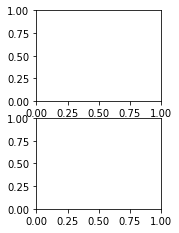

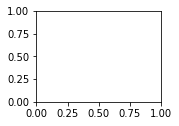

In [132]:
props = {'syn_location':1}
#AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)
show_response_bg_dep(FREE, CHELATED, method='deltaFreq', ylim=[0,9])#, BG_levels=[0,2,4])

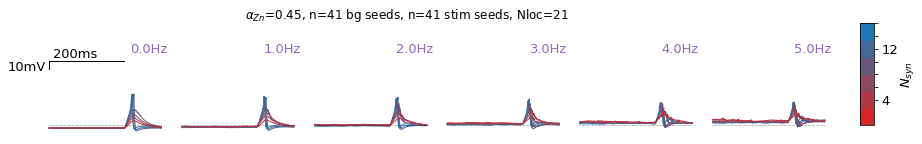

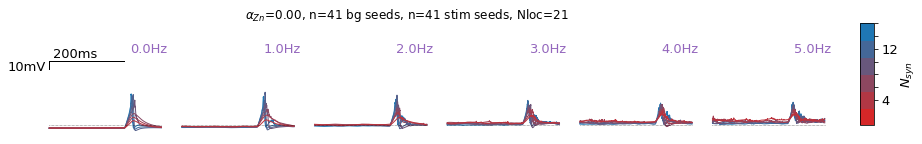

In [90]:
props = {'VLIM':[-86,30], 'syn_location':'all'}
#show_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

In [50]:
args.seed = 12
args.active= True
args.ampa_only = False
args.syn_location = 1
args.bg_level = 2.
# free Zinc data
args.alphaZn = 0.45
#data_L23 = load_dict(filename(args))
# chelated Zinc data
args.alphaZn = 0.
#data_L4 = load_dict(filename(args))
# AMPA-only data
#args.ampa_only = True
#data_AMPA = load_dict(filename(args))

In [16]:
def count_spikes(t, Vm, t0, t1, threshold=0):
    cond = (t>t0) & (t<t1)
    return len(np.argwhere((Vm[cond][:-1]<threshold) & (Vm[cond][1:]>=threshold)))

def count_spikes_per_NSTIM(data, window=200):
    freq = []
    freq0 = 0
    for i in range(len(data['args']['NSTIMs'])):
        t0 = data['args']['stim_delay']+i*data['args']['duration_per_bg_level']
        t1 = t0+data['args']['duration_per_bg_level']
        n = count_spikes(data['t'], data['Vm_soma'], t0, t0+window)
        freq.append(n/window*1e3)
        # using the interstim for the 0 frequency !
        freq0 += count_spikes(data['t'], data['Vm_soma'], t0+window, t1)/(t1-(t0+window))/data['args']['duration_per_bg_level']
    return [0]+list(data['args']['NSTIMs']), [freq0]+freq

In [18]:
from analyz.IO.files_manip import get_files_with_given_exts
from analyz.IO.npz import load_dict
filenames = get_files_with_given_exts('data/bg-modul/', 'active-True.npz')

RESP = {'nstims':[], 'freqs':[]}
K = ['Vm_soma', 't']#, 'BG_raster', 'STIM_raster']
KEYS = ['seed', 'alphaZn','syn_location', 'bg_level']
for key in KEYS+K:
    RESP[key] = []
    
for fn in filenames:
    if not os.path.isdir(fn):
        data = load_dict(fn)
        if np.isfinite(data['Vm_soma'].max()):
            for key in KEYS:
                RESP[key].append(float(data['args'][key]))
            for key in K:
                RESP[key].append(data[key])    
            nstims, freqs = count_spikes_per_NSTIM(data, window=200)
            RESP['nstims'].append(nstims)
            RESP['freqs'].append(freqs)
            
for key in KEYS:
    RESP[key] = np.array(RESP[key])

5

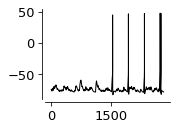

In [221]:
ge.plot(data['t'], data['Vm_soma'])
count_spikes(data['t'], data['Vm_soma'], 0, 1e6)

In [217]:
count_spikes_per_NSTIM(data)

([0, 4, 6, 8, 10, 12, 14, 16], [0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 10.0])

In [208]:
data['args']

{'task': 'run',
 'stim_delay': 300.0,
 'duration_per_bg_level': 400.0,
 'stim_duration': 20,
 'bg_level': 2.0,
 'bg_levels': [2.0],
 'NbgSEEDS': 1,
 'bgSEEDS': [0],
 'syn_location': 6,
 'N_syn_location': 5,
 'Nsyn': 20,
 'NSTIMs': [4, 6, 8, 10, 12, 14, 16],
 'stimSEEDS': [0],
 'syn_locations': [],
 'active': True,
 'ampa_only': False,
 'alphaZn': 0.0,
 'seed': 26,
 'verbose': False}

In [209]:
data['args']['NSTIMs']

[4, 6, 8, 10, 12, 14, 16]

In [210]:
RESP['seed'][RESP['bg_level']==6]

array([18., 30., 33., 27., 30., 26., 22., 32., 19., 27., 28., 24., 31.,
       30., 24., 31., 30., 32., 29., 23., 27., 27., 28., 21., 25., 22.,
       28., 28., 21., 26., 20., 29., 29., 25., 29., 26., 28., 24., 23.,
       26., 21., 22., 27., 26., 34., 26., 23., 21., 18., 24., 22., 31.,
       34., 19., 24., 25., 25., 20., 28., 25., 23., 27., 24., 25., 33.,
       31.])

0  alphaZn cond not found
0.45  alphaZn cond not found


UnboundLocalError: local variable 'i0' referenced before assignment

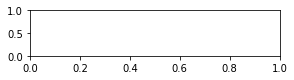

In [19]:
def plot_raw_data(RESP, 
                  alphaZn=[0, 0.45],
                  bg_level=0.,
                  seed=14,
                  COLORS=[ge.green, 'k'],
                  VLIM=[-85, 30]):
    """
    Show raw simulation data
    
    """
    cond = (RESP['bg_level']==bg_level) & (RESP['seed']==seed)
    
    fig, ax = ge.figure(figsize=(2,1))
    
    for aZn, color in zip(alphaZn, COLORS):
        icond = np.argwhere((RESP['bg_level']==bg_level) & (RESP['seed']==seed) & (RESP['alphaZn']==aZn))
        if len(icond)>0:
            i0= icond[0][0]
            ax.plot(RESP['t'][i0], RESP['Vm_soma'][i0], color=color)
        else:
            print(aZn, ' alphaZn cond not found')
    ge.set_plot(ax, [], xlim=[RESP['t'][i0][0], RESP['t'][i0][-1]], ylim=VLIM)
    ge.draw_bar_scales(ax, 
                       Xbar = 100, Xbar_label='100ms',
                       Ybar = 20, Ybar_label='20mV ',
                       loc=(0.1,.9), orientation='right-bottom')

fig = plot_raw_data(RESP, bg_level=0., seed=26, VLIM=[-85,0])

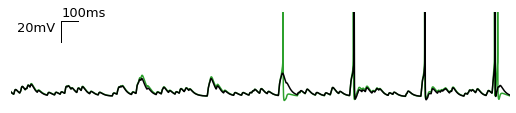

In [214]:
fig = plot_raw_data(RESP, bg_level=2., seed=26, VLIM=[-85,0])

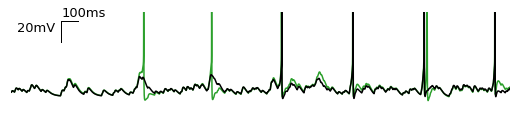

In [215]:
fig = plot_raw_data(RESP, bg_level=4., seed=23, VLIM=[-85,0])

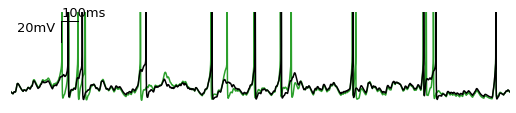

In [216]:
fig = plot_raw_data(RESP, bg_level=6., seed=30, VLIM=[-85,0])

In [128]:
np.unique(RESP['seed'][RESP['bg_level']==4])

array([16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32.])

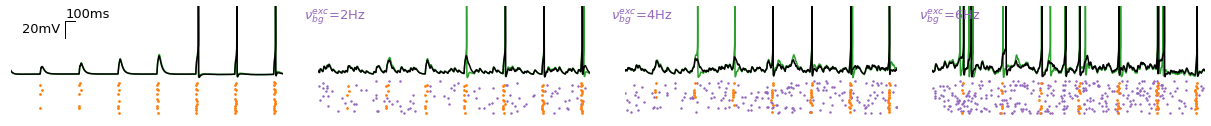

In [241]:
from datavyz import ges as ge
def plot_raw_data_all(RESP, 
                      alphaZn=[0, 0.45],
                      BG_levels=[0., 2., 4., 6.],
                      SEEDS= [26, 26, 23, 30],
                      COLORS=[ge.green, 'k'],
                      VLIM=[-85, 30]):
    """
    Show raw simulation data
    
    """
    #cond = (RESP['bg_level']==bg_level) & (RESP['seed']==seed)
    
    # prepare figure shape
    AE = []
    AE.append([[1,2] for i in range(len(BG_levels))])
    AE.append([[1,1] for i in range(len(BG_levels))])
    fig, AX = ge.figure(axes_extents=AE, figsize=(1.5,.4), wspace=0.2, hspace=0., left=0)

    for ibg, bg_level in enumerate(BG_levels):
        cond = (RESP['bg_level']==bg_level) & (RESP['seed']==SEEDS[ibg])
        
        for aZn, color in zip(alphaZn, COLORS):
            icond = np.argwhere((RESP['bg_level']==bg_level) & (RESP['seed']==SEEDS[ibg]) & (RESP['alphaZn']==aZn))
            if len(icond)>0:
                i0= icond[0][0]
                AX[0][ibg].plot(RESP['t'][i0], RESP['Vm_soma'][i0], color=color)
            else:
                print(aZn, ' alphaZn cond not found')
        ge.set_plot(AX[0][ibg], [], xlim=[RESP['t'][i0][0], RESP['t'][i0][-1]], ylim=VLIM)
    
        for i, sp in enumerate(RESP['BG_raster'][i0]):
            AX[1][ibg].scatter(sp, i*np.ones(len(sp)), color=ge.purple, s=2)
        for i, sp in enumerate(RESP['STIM_raster'][i0]):
            AX[1][ibg].scatter(sp, i*np.ones(len(sp)),  color=ge.orange, s=3)
        if ibg>0:
            ge.annotate(AX[0][ibg], '$\\nu^{exc}_{bg}$=%.0fHz' % bg_level, (-0.05,1), color=ge.purple, va='top')
        ge.set_plot(AX[1][ibg], [], xlim=[RESP['t'][i0][0], RESP['t'][i0][-1]])
        
    ge.draw_bar_scales(AX[0][0], 
                       Xbar = 100, Xbar_label='100ms',
                       Ybar = 20, Ybar_label='20mV ',
                       loc=(0.2,.8), orientation='right-bottom')

    return fig

fig = plot_raw_data_all(RESP, BG_levels=[0,2,4,6], VLIM=[-85, 0])

In [251]:
resp_chelated

NameError: name 'resp_chelated' is not defined

0.0
0.0
3.787878787878788e-07
4.545454545454546e-06
1.5909090909090907e-05
[0, 2, 4, 6, 8]


(<Figure size 249.449x311.811 with 3 Axes>,
 <Figure size 249.449x204.094 with 1 Axes>)

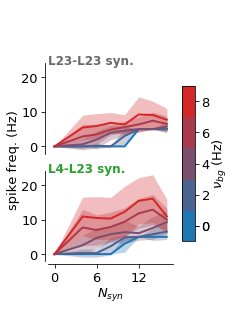

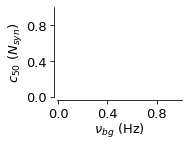

In [277]:
def show_response_bg_dep(RESP,
                         BG_levels=None,
                         NSTIMS = [0, 4, 6, 8, 10, 12, 14, 16],
                         ylim=None):
    
    
    if BG_levels is None:
        BG_levels = np.sort(np.unique(RESP['bg_level']))
        
    FWHM = {'L23':[], 'L4':[]}
            
    fig, AX = ge.figure(axes=(1,2), figsize=(1,1.), hspace=0.3, right=1.5)
    fig2, ax = ge.figure(axes=(1,1), figsize=(1,1.), hspace=0.3, right=1.5)

    for ibg, bg in enumerate(BG_levels):
        bg_cond = (RESP['bg_level']==bg)
        resp_chelated, resp_free = [], []
        for i in np.arange(len(RESP['bg_level']))[bg_cond]:
            if RESP['nstims'][i]==NSTIMS:
                if RESP['alphaZn'][i]==0:
                    resp_chelated.append(RESP['freqs'][i])
                else:
                    resp_free.append(RESP['freqs'][i])
        try:
            ge.plot(RESP['nstims'][0], # they should all have the same NSTIMs !!
                np.array(resp_free).mean(axis=0),sy=np.array(resp_free).std(axis=0),
                color=cmap(ibg/(len(BG_levels)-1)), ax=AX[0], no_set=True, lw=2)
            ge.plot(RESP['nstims'][0], # they should all have the same NSTIMs !!
                np.array(resp_chelated).mean(axis=0),sy=np.array(resp_chelated).std(axis=0),
                color=cmap(ibg/(len(BG_levels)-1)), ax=AX[1], no_set=True, lw=2)
            print(np.array(resp_free).mean(axis=0)[0])
        except BaseException as e:
            print(e)
        
                    
    ge.annotate(AX[0], 'L23-L23 syn.', (0., .95), size='small', color='dimgrey', bold=True)
    ge.annotate(AX[1], 'L4-L23 syn.', (0., .95), size='small', color=ge.green, bold=True)
    
    YLIM = [min([ax.get_ylim()[0] for ax in AX]), max([ax.get_ylim()[1] for ax in AX])]
    ge.set_plot(AX[0], ['left'], ylabel='spike freq. (Hz)'+25*' ', ylim=YLIM)
    ge.set_plot(AX[1], xlabel='$N_{syn}$', ylim=YLIM)
    ge.set_plot(ax, xlabel='$\\nu_{bg}$ (Hz)', ylabel='$c_{50}$ ($N_{syn}$)')
    print(BG_levels)
    ge.bar_legend(fig,
                  X=[0]+list(BG_levels),
                  bounds=[-BG_levels[1]/2., BG_levels[-1]+BG_levels[1]/2.],
                  inset=dict(rect=[.9,.3,.05, .5]),
                  label='$\\nu_{bg}$ (Hz)',
                  colormap=cmap)
    
    return fig, fig2

show_response_bg_dep(RESP, BG_levels=[0,2,4,6,8])

In [246]:
RESP['nstims'][0]

[0, 4, 6, 8, 10, 12, 14, 16]

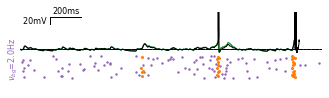

In [85]:
def plot_single_sim(data_L23, data_L4, data_AMPA=None,
            BG_levels=None, NSTIMs=None, BG_seeds=None, 
            COLORS=[ge.blue, ge.green, 'k']):
    """
    Show raw simulation data
    
    """
    args = data_L23['args']
    if BG_levels is None:
        BG_levels = args['bg_levels']
    if NSTIMs is None:
        NSTIMs = args['NSTIMs']
    if BG_seeds is None:
        BG_seeds = np.zeros(len(BG_levels))
    if data_AMPA is None:
        data_AMPA = data_L4
        COLORS[2] = 'k'
        
    # prepare figure shape
    AE = []
    for i in range(len(BG_levels)):
        AE += [[[1,6]], [[1,4]], [[1,1]]]
    fig, AX = ge.figure(axes_extents=AE, figsize=(2.2,.15), hspace=0., left=.2)
    VLIM = [-76, -np.inf]
    for d, data in enumerate([data_AMPA, data_L4, data_L23]):
    
        args = data['args']
        ibg2 = -1
        for ibg, bg in enumerate(args['bg_levels']):
            if bg in BG_levels:
                ibg2 += 1
                istim2 = -1
                for istim, stim in enumerate(args['NSTIMs']):
                    if stim in NSTIMs:
                        istim2 += 1
                        t0 = ibg*len(args['NSTIMs'])*len(args['stimSEEDS'])*len(args['bgSEEDS'])*args['duration_per_bg_level']+\
                            BG_seeds[ibg2]*istim*len(args['stimSEEDS'])*args['duration_per_bg_level']+\
                            istim*len(args['stimSEEDS'])*args['duration_per_bg_level']                        
                        t1 = t0+args['duration_per_bg_level']
                        tcond = (data['t']>=t0) & (data['t']<t1)

                        AX[3*ibg2].plot(data['t'][tcond]-t0+istim2*args['duration_per_bg_level'],
                                        data['Vm_soma'][tcond], color=COLORS[d], lw=1)

                        AX[3*ibg2].plot([0,len(NSTIMs)*args['duration_per_bg_level']], [-75,-75], 'k--', lw=0.5)
                        AX[3*ibg2+1].plot([0,len(NSTIMs)*args['duration_per_bg_level']], [0, 0], 'w.', lw=0)
                        if d==2:
                            for i, sp0 in enumerate(data['BG_raster']):
                                sp = np.array(sp0)
                                cond = (sp>=t0) & (sp<t1)
                                AX[3*ibg2+1].scatter(sp[cond]-t0+istim2*args['duration_per_bg_level'],
                                                     i*np.ones(len(sp[cond])), color=ge.purple, s=2)
                            for i, sp0 in enumerate(data['STIM_raster']):
                                sp = np.array(sp0)
                                cond = (sp>=t0) & (sp<t1)
                                AX[3*ibg2+1].scatter(sp[cond]-t0+istim2*args['duration_per_bg_level'],
                                                     i*np.ones(len(sp[cond])), color=ge.orange, s=4)
                if d==2:
                    ge.annotate(AX[3*ibg2+1], '$\\nu_{bg}$=%.1fHz' % bg, (0,0), color=ge.purple,
                                rotation=90, ha='right')
    VLIM = [-85, 20]
    for ibg, bg in enumerate(BG_levels):
        # ge.annotate(AX[3*ibg],' -75mV', (len(NSTIMs)*args['duration_per_bg_level'],-75),xycoords='data',va='center')
        ge.set_plot(AX[3*ibg], [], xlim=[0,len(NSTIMs)*args['duration_per_bg_level']], ylim=VLIM)
        ge.set_plot(AX[3*ibg+1], [], xlim=[0,len(NSTIMs)*args['duration_per_bg_level']])
        ge.set_plot(AX[3*ibg+2], [], xlim=[t0, t1])
    ge.draw_bar_scales(AX[0], 
                            Xbar = 200, Xbar_label='200ms',
                            Ybar = 20, Ybar_label='20mV ',
                            loc=(0.1,.9), orientation='right-bottom')
    return fig

fig = plot_single_sim(data_L23, data_L4)

# Summary figure

In [394]:
from datavyz import ge
ge.multipanel_figure([['figures/fig_BG12.svg']],
                     LABELS=[['a']],
                     width='double-column', # can also be "single-column" or "one-and-a-half-column"
                     fig_name='figures/Fig_model_Bg-sensitivity.svg',
                     grid=False, # switch to True to get the Grid position and pricesely place labels if necessary
                     export_to_png=True,
                     autoposition=True)

RUNNING: inkscape figures/Fig_model_Bg-sensitivity.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/Fig_model_Bg-sensitivity.png" --export-dpi=300
[ok] figure successfully exported as: figures/Fig_model_Bg-sensitivity.png


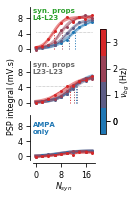

In [351]:
from datavyz import ge
props = {'syn_location':0, 'NSTIMS':np.arange(0, 20, 2), 'integral_window':[0,300]}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)
fig_BG12 = show_response_bg_dep(FREE, CHELATED, AMPA=AMPA, method='Integral', ge=ge,
                                 ylim=[-1,11], BG_levels=[0,1,2,3],crossing=4.5)
fig_BG12.savefig('figures/fig_BG12.svg')

In [393]:
ge.multipanel_figure?